In [9]:
# Import libraries
## Basic libs
import pandas as pd
import numpy as np
import warnings
## Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.compose import ColumnTransformer
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from joblib import dump, load
import pickle
import joblib

# Configure libraries
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (10, 10)
plt.style.use('seaborn')

In [7]:
# Load dataset
df_bank = pd.read_csv('./data/bank.csv')


# print(df_bank.info())
print('Shape of dataframe:', df_bank.shape)
df_bank.head()

Shape of dataframe: (11162, 17)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


## Class Distribution

In [8]:
df_bank['deposit'].value_counts()

no     5873
yes    5289
Name: deposit, dtype: int64

## Missing Values

In [4]:
df_bank.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
deposit      0
dtype: int64

## Data preprocessing

In [44]:
# Select Features
feature = df_bank.drop('deposit', axis=1)

# Select Target
target = df_bank['deposit'].apply(lambda deposit: 1 if deposit == 'yes' else 0)

# Set Training and Testing Data
X_train, X_test, y_train, y_test = train_test_split(feature , target, 
                                                    shuffle = True, 
                                                    test_size=0.2, 
                                                    random_state=1)

# Show the Training and Testing Data
print('Shape of training feature:', X_train.shape)
print('Shape of testing feature:', X_test.shape)
print('Shape of training label:', y_train.shape)
print('Shape of training label:', y_test.shape)

Shape of training feature: (8929, 16)
Shape of testing feature: (2233, 16)
Shape of training label: (8929,)
Shape of training label: (2233,)


In [45]:
numeric_columns = ['age', 'balance', 'day', 'campaign', 'pdays', 'previous']
categorical_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']

scaler = StandardScaler()
one_hot_encoder = OneHotEncoder()

preprocessor = ColumnTransformer(transformers=[
    ('num', scaler, numeric_columns),
    ('cat', one_hot_encoder, categorical_columns)
])

preprocessor.fit(feature)

ColumnTransformer(transformers=[('num', StandardScaler(),
                                 ['age', 'balance', 'day', 'campaign', 'pdays',
                                  'previous']),
                                ('cat', OneHotEncoder(),
                                 ['job', 'marital', 'education', 'default',
                                  'housing', 'loan', 'contact', 'month',
                                  'poutcome'])])

In [46]:
X_train_preprocessed = preprocessor.transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

In [47]:
def evaluate_model(model, x_test, y_test):
    from sklearn import metrics

    # Predict Test Data 
    y_pred = model.predict(x_test)

    # Calculate accuracy, precision, recall, f1-score, and kappa score
    acc = metrics.accuracy_score(y_test, y_pred)
    prec = metrics.precision_score(y_test, y_pred)
    rec = metrics.recall_score(y_test, y_pred)
    f1 = metrics.f1_score(y_test, y_pred)
    kappa = metrics.cohen_kappa_score(y_test, y_pred)

    # Calculate area under curve (AUC)
    y_pred_proba = model.predict_proba(x_test)[::,1]
    fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
    auc = metrics.roc_auc_score(y_test, y_pred_proba)

    # Display confussion matrix
    cm = metrics.confusion_matrix(y_test, y_pred)

    return {'acc': acc, 'prec': prec, 'rec': rec, 'f1': f1, 'kappa': kappa, 
            'fpr': fpr, 'tpr': tpr, 'auc': auc, 'cm': cm}

## Use 3 ML models
- Decision Tree
- Random forest
- NB

In [48]:
# Building Decision Tree model 
dtc = tree.DecisionTreeClassifier(random_state=0)
dtc.fit(X_train_preprocessed, y_train)

# Evaluate Model
dtc_eval = evaluate_model(dtc, X_test_preprocessed, y_test)

# Print result
print('Accuracy:', dtc_eval['acc'])
print('Precision:', dtc_eval['prec'])
print('Recall:', dtc_eval['rec'])
print('F1 Score:', dtc_eval['f1'])
print('Cohens Kappa Score:', dtc_eval['kappa'])
print('Area Under Curve:', dtc_eval['auc'])
print('Confusion Matrix:\n', dtc_eval['cm'])

Accuracy: 0.632333184057322
Precision: 0.6207233626588465
Recall: 0.5945692883895131
F1 Score: 0.6073648971783836
Cohens Kappa Score: 0.2619816229381158
Area Under Curve: 0.630761039044542
Confusion Matrix:
 [[777 388]
 [433 635]]


In [49]:
# Building Random Forest model 
rf = RandomForestClassifier(random_state=0)
rf.fit(X_train_preprocessed, y_train)

# Evaluate Model
rf_eval = evaluate_model(rf, X_test_preprocessed, y_test)

# Print result
print('Accuracy:', rf_eval['acc'])
print('Precision:', rf_eval['prec'])
print('Recall:', rf_eval['rec'])
print('F1 Score:', rf_eval['f1'])
print('Cohens Kappa Score:', rf_eval['kappa'])
print('Area Under Curve:', rf_eval['auc'])
print('Confusion Matrix:\n', rf_eval['cm'])

Accuracy: 0.7147335423197492
Precision: 0.7397107897664071
Recall: 0.6226591760299626
F1 Score: 0.6761565836298933
Cohens Kappa Score: 0.42459791419823334
Area Under Curve: 0.7764864734532478
Confusion Matrix:
 [[931 234]
 [403 665]]


In [50]:
# Building Naive Bayes model 
nb = GaussianNB()
nb.fit(X_train_preprocessed, y_train)

# Evaluate Model
nb_eval = evaluate_model(nb, X_test_preprocessed, y_test)

# Print result
print('Accuracy:', nb_eval['acc'])
print('Precision:', nb_eval['prec'])
print('Recall:', nb_eval['rec'])
print('F1 Score:', nb_eval['f1'])
print('Cohens Kappa Score:', nb_eval['kappa'])
print('Area Under Curve:', nb_eval['auc'])
print('Confusion Matrix:\n', nb_eval['cm'])

Accuracy: 0.6815942678011644
Precision: 0.7560975609756098
Recall: 0.4934456928838951
F1 Score: 0.5971671388101983
Cohens Kappa Score: 0.352622455965517
Area Under Curve: 0.7421999324878237
Confusion Matrix:
 [[995 170]
 [541 527]]


In [51]:
# Building KNN model 
knn = KNeighborsClassifier()
knn.fit(X_train_preprocessed, y_train)

# Evaluate Model
knn_eval = evaluate_model(knn, X_test_preprocessed, y_test)

# Print result
print('Accuracy:', knn_eval['acc'])
print('Precision:', knn_eval['prec'])
print('Recall:', knn_eval['rec'])
print('F1 Score:', knn_eval['f1'])
print('Cohens Kappa Score:', knn_eval['kappa'])
print('Area Under Curve:', knn_eval['auc'])
print('Confusion Matrix:\n', knn_eval['cm'])

Accuracy: 0.6869682042095835
Precision: 0.6981740064446831
Recall: 0.6086142322097379
F1 Score: 0.6503251625812906
Cohens Kappa Score: 0.3693851405429406
Area Under Curve: 0.7323909758724342
Confusion Matrix:
 [[884 281]
 [418 650]]


## Model comparison

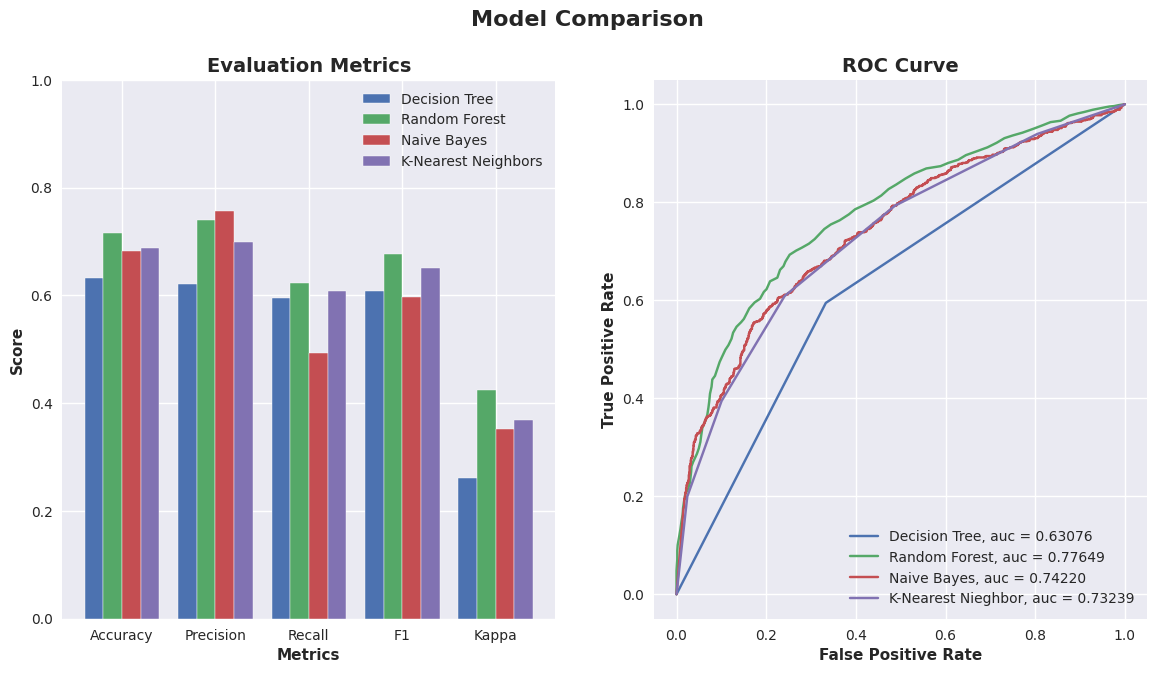

In [52]:
# Intitialize figure with two plots
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Model Comparison', fontsize=16, fontweight='bold')
fig.set_figheight(7)
fig.set_figwidth(14)
fig.set_facecolor('white')

# First plot
## set bar size
barWidth = 0.2
dtc_score = [dtc_eval['acc'], dtc_eval['prec'], dtc_eval['rec'], dtc_eval['f1'], dtc_eval['kappa']]
rf_score = [rf_eval['acc'], rf_eval['prec'], rf_eval['rec'], rf_eval['f1'], rf_eval['kappa']]
nb_score = [nb_eval['acc'], nb_eval['prec'], nb_eval['rec'], nb_eval['f1'], nb_eval['kappa']]
knn_score = [knn_eval['acc'], knn_eval['prec'], knn_eval['rec'], knn_eval['f1'], knn_eval['kappa']]

## Set position of bar on X axis
r1 = np.arange(len(dtc_score))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]

## Make the plot
ax1.bar(r1, dtc_score, width=barWidth, edgecolor='white', label='Decision Tree')
ax1.bar(r2, rf_score, width=barWidth, edgecolor='white', label='Random Forest')
ax1.bar(r3, nb_score, width=barWidth, edgecolor='white', label='Naive Bayes')
ax1.bar(r4, knn_score, width=barWidth, edgecolor='white', label='K-Nearest Neighbors')

## Configure x and y axis
ax1.set_xlabel('Metrics', fontweight='bold')
labels = ['Accuracy', 'Precision', 'Recall', 'F1', 'Kappa']
ax1.set_xticks([r + (barWidth * 1.5) for r in range(len(dtc_score))], )
ax1.set_xticklabels(labels)
ax1.set_ylabel('Score', fontweight='bold')
ax1.set_ylim(0, 1)

## Create legend & title
ax1.set_title('Evaluation Metrics', fontsize=14, fontweight='bold')
ax1.legend()

# Second plot
## Comparing ROC Curve
ax2.plot(dtc_eval['fpr'], dtc_eval['tpr'], label='Decision Tree, auc = {:0.5f}'.format(dtc_eval['auc']))
ax2.plot(rf_eval['fpr'], rf_eval['tpr'], label='Random Forest, auc = {:0.5f}'.format(rf_eval['auc']))
ax2.plot(nb_eval['fpr'], nb_eval['tpr'], label='Naive Bayes, auc = {:0.5f}'.format(nb_eval['auc']))
ax2.plot(knn_eval['fpr'], knn_eval['tpr'], label='K-Nearest Nieghbor, auc = {:0.5f}'.format(knn_eval['auc']))

## Configure x and y axis
ax2.set_xlabel('False Positive Rate', fontweight='bold')
ax2.set_ylabel('True Positive Rate', fontweight='bold')

## Create legend & title
ax2.set_title('ROC Curve', fontsize=14, fontweight='bold')
ax2.legend(loc=4)

plt.show()

## Prediction

In [53]:
df_bank

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,33,blue-collar,single,primary,no,1,yes,no,cellular,20,apr,257,1,-1,0,unknown,no
11158,39,services,married,secondary,no,733,no,no,unknown,16,jun,83,4,-1,0,unknown,no
11159,32,technician,single,secondary,no,29,no,no,cellular,19,aug,156,2,-1,0,unknown,no
11160,43,technician,married,secondary,no,0,no,yes,cellular,8,may,9,2,172,5,failure,no


In [54]:
feature

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,33,blue-collar,single,primary,no,1,yes,no,cellular,20,apr,257,1,-1,0,unknown
11158,39,services,married,secondary,no,733,no,no,unknown,16,jun,83,4,-1,0,unknown
11159,32,technician,single,secondary,no,29,no,no,cellular,19,aug,156,2,-1,0,unknown
11160,43,technician,married,secondary,no,0,no,yes,cellular,8,may,9,2,172,5,failure


In [55]:
feature.iloc[0:2]

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown


In [59]:
from sklearn.pipeline import Pipeline
import json
result = feature.iloc[0:2].to_json(orient="split")
parsed = json.loads(result)
print(json.dumps(parsed, indent=4))

{
    "columns": [
        "age",
        "job",
        "marital",
        "education",
        "default",
        "balance",
        "housing",
        "loan",
        "contact",
        "day",
        "month",
        "duration",
        "campaign",
        "pdays",
        "previous",
        "poutcome"
    ],
    "index": [
        0,
        1
    ],
    "data": [
        [
            59,
            "admin.",
            "married",
            "secondary",
            "no",
            2343,
            "yes",
            "no",
            "unknown",
            5,
            "may",
            1042,
            1,
            -1,
            0,
            "unknown"
        ],
        [
            56,
            "admin.",
            "married",
            "secondary",
            "no",
            45,
            "no",
            "no",
            "unknown",
            5,
            "may",
            1467,
            1,
            -1,
            0,
            "unkn

In [61]:
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', rf)
])

df_bank['deposit_prediction'] = pipeline.predict(feature)
df_bank['deposit_prediction'] = df_bank['deposit_prediction'].apply(lambda x: 'yes' if x==0 else 'no')


df_bank.head(10)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit,deposit_prediction
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes,no
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes,no
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes,no
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes,no
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes,yes
5,42,management,single,tertiary,no,0,yes,yes,unknown,5,may,562,2,-1,0,unknown,yes,no
6,56,management,married,tertiary,no,830,yes,yes,unknown,6,may,1201,1,-1,0,unknown,yes,yes
7,60,retired,divorced,secondary,no,545,yes,no,unknown,6,may,1030,1,-1,0,unknown,yes,yes
8,37,technician,married,secondary,no,1,yes,no,unknown,6,may,608,1,-1,0,unknown,yes,no
9,28,services,single,secondary,no,5090,yes,no,unknown,6,may,1297,3,-1,0,unknown,yes,no


In [62]:
## Save as a pickle file
filename= 'bank_deposit_classification.pkl'
joblib.dump(pipeline,open(filename, 'wb'))